<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Dimensional analysis example - pump flow
In this example, we will find an appropriate set of dimensionless parameters that
relate pressure increase across a pump to the flow rate through the pump. We start
with the basic expectation that pressure increase $\Delta p$ should depend on $D$
(the diameter of the pump), $\rho$ (the fluid density), $\omega$ (the rotational speed),
and $Q$ (the volume flow rate)

$$\Delta p = f(D,\rho,\omega,Q)$$

### Set up the module

In [1]:
using FluidDynTools

In [2]:
using Plots
using Serialization # to read/write data

### Read in some raw data
First, we will read in some raw experimental data for a pump of diameter 12 in.
These data give the measured pressure rise (as *head increase*, $h_p$, units of meters)
vs volume flow rate (in units of cubic meters per second).

We will load in data for pump speeds of 250, 500 and 1000 rpm. For later convenience,
we will put all of these data into one data structure called `pumpdata`.

In [3]:
pumpdata = deserialize("pumpdata.jls")

Dict{String, Dict{String, Vector}} with 3 entries:
  "500rpm"  => Dict("Q"=>Quantity{Float64, 𝐋³ 𝐓⁻¹, FreeUnits{(m³, s⁻¹), 𝐋³ 𝐓⁻¹,…
  "1000rpm" => Dict("Q"=>Quantity{Float64, 𝐋³ 𝐓⁻¹, FreeUnits{(m³, s⁻¹), 𝐋³ 𝐓⁻¹,…
  "250rpm"  => Dict("Q"=>Quantity{Float64, 𝐋³ 𝐓⁻¹, FreeUnits{(m³, s⁻¹), 𝐋³ 𝐓⁻¹,…

The data are in the form of a `Dict` (short for dictionary). For example,
to get the flow rates for speed 500 rpm,

In [4]:
Q500 = pumpdata["500rpm"]["Q"]

8-element Vector{Unitful.Quantity{Float64, 𝐋³ 𝐓⁻¹, Unitful.FreeUnits{(m³, s⁻¹), 𝐋³ 𝐓⁻¹, nothing}}}:
                  0.0 m³ s⁻¹
 0.020969142203331865 m³ s⁻¹
  0.04193828440666373 m³ s⁻¹
  0.06290742660999558 m³ s⁻¹
  0.08387656881332746 m³ s⁻¹
  0.10484571101665932 m³ s⁻¹
  0.12581485321999117 m³ s⁻¹
  0.14678399542332304 m³ s⁻¹

and the associated head increases are

In [5]:
h500 = pumpdata["500rpm"]["head"]

8-element Vector{Unitful.Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
  5.664863501386198 m
  5.678840855291137 m
  5.647258945899934 m
  5.657487429925689 m
  5.246758181966145 m
  4.755642659695044 m
  3.671452441175552 m
 0.9659942449994097 m

To convert the flow rate data to liters/minute (lpm), for example

In [6]:
value.(VolumeFlowRate.(Q500),u"L/minute")

8-element Vector{Unitful.Quantity{Float64, 𝐋³ 𝐓⁻¹, Unitful.FreeUnits{(L, minute⁻¹), 𝐋³ 𝐓⁻¹, nothing}}}:
                0.0 L minute⁻¹
 1258.1485321999119 L minute⁻¹
 2516.2970643998237 L minute⁻¹
  3774.445596599735 L minute⁻¹
 5032.5941287996475 L minute⁻¹
  6290.742660999559 L minute⁻¹
   7548.89119319947 L minute⁻¹
  8807.039725399383 L minute⁻¹

or head increase to ft

In [7]:
value.(Head.(h500),u"ft")

8-element Vector{Unitful.Quantity{Float64, 𝐋, Unitful.FreeUnits{(ft,), 𝐋, nothing}}}:
  18.58551017515157 ft
  18.63136763546961 ft
 18.527752447178262 ft
 18.561310465635465 ft
 17.213773562881055 ft
  15.60250216435382 ft
 12.045447641652073 ft
 3.1692724573471445 ft

Let's plot this data

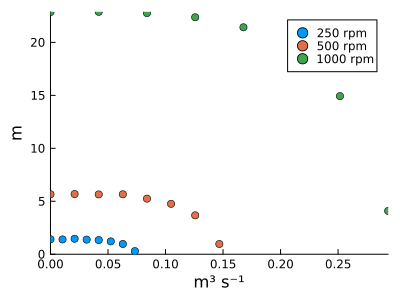

In [8]:
scatter(xlabel=L"$Q$",ylabel=L"$h$",legend=true,xlims=(0,Inf),ylims=(0,Inf))
scatter!(pumpdata["250rpm"]["Q"],pumpdata["250rpm"]["head"],label="250 rpm")
scatter!(pumpdata["500rpm"]["Q"],pumpdata["500rpm"]["head"],label="500 rpm")
scatter!(pumpdata["1000rpm"]["Q"],pumpdata["1000rpm"]["head"],label="1000 rpm")

The data don't appear very similar to each other, except for a rough shape.
And more importantly, these are only curves for three pump speeds. What if
we want to predict the performance at, say, 700 rpm?

### Find a suitable set of dimensionless parameters ($\Pi$ groups)
Here, we should think of $\Delta p$ as the dependent variable and $Q$ as the
independent variable -- this is what defines a pump's characteristics. The other
quantities are the reference quantities. It is straightforward to come up with the
$\Pi$ groups:

$$\dfrac{\Delta p}{\rho \omega^2 D^2} = f \left( \dfrac{Q}{\omega D^3} \right)$$

### Rewrite the first $\Pi$ group in terms of the pump's head gain, $h_p$.
From the energy equation, $h_p + p_1/\rho g = p_2/\rho g$, where $\Delta p = p_2 - p_1$.
Thus, we can rewrite the first $\Pi$ group in terms of $h_p$, so that the relationship is

$$\dfrac{g h_p}{\omega^2 D^2} = f \left( \dfrac{Q}{\omega D^3} \right)$$

The dimensionless flow rate is called the *flow coefficient*, and the
dimensionless head is called the *head rise coefficient*.

### Calculate the $\Pi$ groups and plot them on the same plot
We will now use the raw dimensional data in `pumpdata` to calculate the
$\Pi$ groups. We set the basic parameters here:

In [9]:
D = 12u"inch"
g = 1u"ge" # This is Earth's gravitation constant

1 ge

So, let's say we want to calculate the flow coefficient at 250 rpm:

In [10]:
omega = 250u"rpm"
pumpdata["250rpm"]["Q"]/(omega*D^3)

8-element Vector{Unitful.Quantity{Float64, NoDims, Unitful.FreeUnits{(inch⁻³, m³, rpm⁻¹, s⁻¹), NoDims, nothing}}}:
                   0.0 m³ inch⁻³ rpm⁻¹ s⁻¹
 2.4269840513115586e-8 m³ inch⁻³ rpm⁻¹ s⁻¹
  4.853968102623117e-8 m³ inch⁻³ rpm⁻¹ s⁻¹
  7.280952153934674e-8 m³ inch⁻³ rpm⁻¹ s⁻¹
  9.707936205246234e-8 m³ inch⁻³ rpm⁻¹ s⁻¹
 1.2134920256557793e-7 m³ inch⁻³ rpm⁻¹ s⁻¹
  1.456190430786935e-7 m³ inch⁻³ rpm⁻¹ s⁻¹
 1.6988888359180908e-7 m³ inch⁻³ rpm⁻¹ s⁻¹

It looks like the data have units! But on closer inspection, they are
actually units that will cancel (with appropriate conversions). We can make that
happen by using the `DimensionlessParameter` function. (We use this in
vectorized form on each element in the array.) We'll assign the result to
a new key in the `Dict`, called `Q_nd`:

In [11]:
pumpdata["250rpm"]["Q_nd"] = DimensionlessParameter.(pumpdata["250rpm"]["Q"]/(omega*D^3))

8-element Vector{DimensionlessParameter{Float64}}:
                  DimensionlessParameter = 0.0
 DimensionlessParameter = 0.014142857142857148
 DimensionlessParameter = 0.028285714285714296
  DimensionlessParameter = 0.04242857142857144
  DimensionlessParameter = 0.05657142857142859
  DimensionlessParameter = 0.07071428571428574
  DimensionlessParameter = 0.08485714285714288
  DimensionlessParameter = 0.09900000000000002

Similarly for the head rise coefficient, which we call head_nd here:

In [12]:
pumpdata["250rpm"]["head_nd"] = DimensionlessParameter.(pumpdata["250rpm"]["head"]*g/(omega^2*D^2))

8-element Vector{DimensionlessParameter{Float64}}:
  DimensionlessParameter = 0.21732590812529953
  DimensionlessParameter = 0.21528052952331342
  DimensionlessParameter = 0.22480062106650103
   DimensionlessParameter = 0.2125877858020672
  DimensionlessParameter = 0.20572175190950573
  DimensionlessParameter = 0.18669657968818104
   DimensionlessParameter = 0.1492482500323153
 DimensionlessParameter = 0.045387702368839565

Let's do the same at 500 and 1000 rpm

In [13]:
omega = 500u"rpm"
pumpdata["500rpm"]["Q_nd"] = DimensionlessParameter.(pumpdata["500rpm"]["Q"]/(omega*D^3))
pumpdata["500rpm"]["head_nd"] = DimensionlessParameter.(pumpdata["500rpm"]["head"]*g/(omega^2*D^2));

In [14]:
omega = 1000u"rpm"
pumpdata["1000rpm"]["Q_nd"] = DimensionlessParameter.(pumpdata["1000rpm"]["Q"]/(omega*D^3))
pumpdata["1000rpm"]["head_nd"] = DimensionlessParameter.(pumpdata["1000rpm"]["head"]*g/(omega^2*D^2));

Now plot these

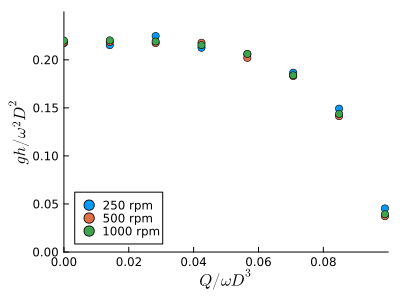

In [15]:
scatter(xlabel=L"$Q/\omega D^3$",ylabel=L"$gh/\omega^2 D^2$",legend=:bottomleft,xlims=(0,0.1),ylims=(0,0.25))
scatter!(pumpdata["250rpm"]["Q_nd"],pumpdata["250rpm"]["head_nd"],label="250 rpm")
scatter!(pumpdata["500rpm"]["Q_nd"],pumpdata["500rpm"]["head_nd"],label="500 rpm")
scatter!(pumpdata["1000rpm"]["Q_nd"],pumpdata["1000rpm"]["head_nd"],label="1000 rpm")

The data collapse onto a single curve. This reveals the power of dimensional
analysis! One would follow up by generating a statistical correlation
between the two dimensionless parameters. Then, we could use this correlation
to predict performance at any pump speed or pump diameter!

In [16]:
#savefig("pumpplot.pdf")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*